# Báo cáo về Mô hình Phân loại Mã độc sử dụng Random Forest

## 1. Giới thiệu
Mã độc là một trong những mối đe dọa lớn nhất đối với an ninh mạng. Việc phát hiện và phân loại mã độc là rất quan trọng để bảo vệ hệ thống và dữ liệu. Trong báo cáo này, chúng tôi sẽ xây dựng mô hình Random Forest để phát hiện mã độc từ một tập dữ liệu có sẵn. Mô hình sẽ được đánh giá bằng độ chính xác và các biểu đồ phân tích kết quả.

## 2. Tải và Khám Phá Dữ Liệu


Chúng tôi bắt đầu bằng việc tải dữ liệu từ file CSV sử dụng thư viện pandas.

In [61]:
import pandas as pd
import numpy as np

# Tải dữ liệu
data = pd.read_csv('TUANDROMD.csv')

# Khám phá dữ liệu
print(data.head())
print(data.describe())
print(data.isnull().sum())


   ACCESS_ALL_DOWNLOADS  ACCESS_CACHE_FILESYSTEM  ACCESS_CHECKIN_PROPERTIES  \
0                   0.0                      0.0                        0.0   
1                   0.0                      0.0                        0.0   
2                   0.0                      0.0                        0.0   
3                   0.0                      0.0                        0.0   
4                   0.0                      0.0                        0.0   

   ACCESS_COARSE_LOCATION  ACCESS_COARSE_UPDATES  ACCESS_FINE_LOCATION  \
0                     0.0                    0.0                   0.0   
1                     0.0                    0.0                   0.0   
2                     0.0                    0.0                   0.0   
3                     0.0                    0.0                   0.0   
4                     0.0                    0.0                   0.0   

   ACCESS_LOCATION_EXTRA_COMMANDS  ACCESS_MOCK_LOCATION  ACCESS_MTK_MMHW  \
0   

### Kết quả khám phá:

- head(): Giúp nắm bắt được các đặc trưng của dữ liệu.
- describe(): Cung cấp thông tin về giá trị tối thiểu, tối đa, trung bình, v.v., của các đặc trưng số.
- isnull().sum(): Giúp xác định xem có giá trị nào bị thiếu hay không.

## 3. Tiền Xử Lý Dữ Liệu và Chia tập huấn luyện và tập kiểm tra

In [62]:
# Chia dữ liệu thành X (các đặc điểm) và y (nhãn)
X = data.drop('Label', axis=1).values
y = data['Label'].values

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
np.random.seed(42)  # Để tái tạo kết quả
indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))
X_train, X_test = X[indices[:train_size]], X[indices[train_size:]]
y_train, y_test = y[indices[:train_size]], y[indices[train_size:]]


## 4. Xây Dựng Mô Hình Random Forest
Chúng tôi xây dựng lớp DecisionTree và RandomForest. Lớp DecisionTree được sử dụng để tạo các cây quyết định riêng lẻ, trong khi lớp RandomForest kết hợp nhiều cây để đưa ra dự đoán cuối cùng.

### 4.1. Lớp DecisionTree

In [63]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=3):
        # Khởi tạo cây quyết định với độ sâu tối đa
        self.max_depth = max_depth
        self.tree = None  # Biến để lưu trữ cây

    def fit(self, X, y):
        """
        Huấn luyện mô hình trên dữ liệu X và nhãn y.
        X: Ma trận đặc trưng (features) chứa các thuộc tính của mẫu.
        y: Mảng nhãn (labels) tương ứng với các mẫu trong X.
        """
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        """
        Xây dựng cây quyết định dựa trên dữ liệu X và nhãn y.
        depth: Độ sâu hiện tại của cây.
        Trả về một nút của cây quyết định.
        """
        num_samples, num_features = X.shape
        # Kiểm tra các điều kiện dừng
        if num_samples == 0 or depth == self.max_depth or len(set(y)) == 1:
            return np.mean(y)  # Trả về giá trị trung bình nếu đạt điều kiện dừng

        # Tìm split tốt nhất
        best_feature, best_threshold = self._best_split(X, y)

        if best_feature is None:
            return np.mean(y)  # Trả về giá trị trung bình nếu không tìm thấy split tốt nhất

        # Chia dữ liệu thành hai nhánh
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold

        # Gọi đệ quy để xây dựng cây con cho hai nhánh
        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_tree, right_tree)  # Trả về thông tin về split tốt nhất

    def _best_split(self, X, y):
        """
        Tìm split tốt nhất trong dữ liệu.
        X: Ma trận đặc trưng (features).
        y: Mảng nhãn (labels).
        Trả về chỉ số thuộc tính tốt nhất và ngưỡng tương ứng để chia dữ liệu.
        """
        best_feature, best_threshold = None, None
        best_impurity = float('inf')  # Khởi tạo impurity tốt nhất

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])  # Các giá trị duy nhất của feature
            for threshold in thresholds:
                # Chia dữ liệu dựa trên threshold
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue  # Bỏ qua nếu một nhánh rỗng

                # Tính toán impurity cho split này
                impurity = self._gini_index(y[left_indices], y[right_indices])

                # Cập nhật split tốt nhất nếu tìm thấy impurity tốt hơn
                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold  # Trả về feature và threshold tốt nhất

    def _gini_index(self, left_y, right_y):
        """
        Tính toán gini index cho một split.
        left_y: Mảng nhãn cho nhánh bên trái.
        right_y: Mảng nhãn cho nhánh bên phải.
        Trả về giá trị gini index có trọng số cho cả hai nhánh.
        """
        m = len(left_y) + len(right_y)  # Tổng số mẫu
        if m == 0:
            return 0
        # Tính toán gini index có trọng số cho cả hai nhánh
        return (len(left_y) / m) * self._gini(left_y) + (len(right_y) / m) * self._gini(right_y)

    def _gini(self, y):
        """
        Tính toán gini index cho một nhãn y.
        y: Mảng nhãn cần tính toán gini index.
        Trả về giá trị gini index cho nhãn y.
        """
        m = len(y)  # Số lượng mẫu
        if m == 0:
            return 0
        p1 = np.sum(y) / m  # Tỷ lệ của lớp 1
        p0 = 1 - p1  # Tỷ lệ của lớp 0
        # Công thức tính gini index
        return 1 - p1**2 - p0**2

    def predict(self, X):
        """
        Dự đoán nhãn cho các mẫu mới.
        X: Ma trận đặc trưng (features) của các mẫu cần dự đoán.
        Trả về mảng nhãn dự đoán tương ứng.
        """
        return np.array([self._predict_sample(sample, self.tree) for sample in X])

    def _predict_sample(self, sample, tree):
        """
        Dự đoán nhãn cho một mẫu đơn.
        sample: Mẫu đơn cần dự đoán.
        tree: Cây quyết định đã xây dựng.
        Trả về nhãn dự đoán cho mẫu.
        """
        if isinstance(tree, tuple):
            feature, threshold, left_tree, right_tree = tree  # Tách thông tin từ cây
            if sample[feature] < threshold:
                return self._predict_sample(sample, left_tree)  # Tiếp tục ở nhánh trái
            else:
                return self._predict_sample(sample, right_tree)  # Tiếp tục ở nhánh phải
        return 1 if tree > 0.5 else 0  # Dự đoán nhãn 1 nếu giá trị lớn hơn 0.5, ngược lại là 0


In [64]:
# class DecisionTree:
#     def __init__(self, max_depth=3):
#         self.max_depth = max_depth
#         self.tree = None

#     def fit(self, X, y):
#         self.tree = self._build_tree(X, y)

#     def _build_tree(self, X, y, depth=0):
#         num_samples, num_features = X.shape
#         if num_samples == 0 or depth == self.max_depth or len(set(y)) == 1:
#             return np.mean(y)

#         best_feature, best_threshold = self._best_split(X, y)

#         if best_feature is None:
#             return np.mean(y)

#         left_indices = X[:, best_feature] < best_threshold
#         right_indices = X[:, best_feature] >= best_threshold

#         left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
#         right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

#         return (best_feature, best_threshold, left_tree, right_tree)

#     def _best_split(self, X, y):
#         best_feature, best_threshold = None, None
#         best_impurity = float('inf')

#         for feature in range(X.shape[1]):
#             thresholds = np.unique(X[:, feature])
#             for threshold in thresholds:
#                 left_indices = X[:, feature] < threshold
#                 right_indices = X[:, feature] >= threshold

#                 if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
#                     continue

#                 impurity = self._gini_index(y[left_indices], y[right_indices])

#                 if impurity < best_impurity:
#                     best_impurity = impurity
#                     best_feature = feature
#                     best_threshold = threshold

#         return best_feature, best_threshold

#     def _gini_index(self, left_y, right_y):
#         m = len(left_y) + len(right_y)
#         if m == 0:
#             return 0
#         return (len(left_y) / m) * self._gini(left_y) + (len(right_y) / m) * self._gini(right_y)

#     def _gini(self, y):
#         m = len(y)
#         if m == 0:
#             return 0
#         p1 = np.sum(y) / m
#         p0 = 1 - p1
#         return 1 - p1**2 - p0**2

#     def predict(self, X):
#         return np.array([self._predict_sample(sample, self.tree) for sample in X])

#     def _predict_sample(self, sample, tree):
#         if isinstance(tree, tuple):
#             feature, threshold, left_tree, right_tree = tree
#             if sample[feature] < threshold:
#                 return self._predict_sample(sample, left_tree)
#             else:
#                 return self._predict_sample(sample, right_tree)
#         return 1 if tree > 0.5 else 0




### 4.2. Lớp RandomForest

In [65]:
import numpy as np

class RandomForest:
    def __init__(self, n_trees=200, max_depth=5):
        """
        Khởi tạo mô hình rừng ngẫu nhiên với số lượng cây và độ sâu tối đa.
        n_trees: Số lượng cây trong rừng.
        max_depth: Độ sâu tối đa cho mỗi cây.
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []  # Danh sách để lưu trữ các cây quyết định

    def fit(self, X, y):
        """
        Huấn luyện mô hình rừng ngẫu nhiên trên dữ liệu X và nhãn y.
        X: Ma trận đặc trưng (features) chứa các thuộc tính của mẫu.
        y: Mảng nhãn (labels) tương ứng với các mẫu trong X.
        """
        num_samples = X.shape[0]  # Số lượng mẫu trong tập dữ liệu
        for _ in range(self.n_trees):
            # Chọn ngẫu nhiên mẫu với hoàn lại (bootstrap sampling)
            indices = np.random.choice(num_samples, size=num_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]  # Tạo mẫu ngẫu nhiên
            tree = DecisionTree(max_depth=self.max_depth)  # Tạo cây quyết định mới
            tree.fit(X_sample, y_sample)  # Huấn luyện cây trên mẫu ngẫu nhiên
            self.trees.append(tree)  # Thêm cây vào danh sách

    def predict(self, X):
        """
        Dự đoán nhãn cho các mẫu mới.
        X: Ma trận đặc trưng (features) của các mẫu cần dự đoán.
        Trả về mảng nhãn dự đoán tương ứng.
        """
        tree_preds = np.array([tree.predict(X) for tree in self.trees])  # Dự đoán từ tất cả các cây
        # Trả về nhãn với số lượng lớn nhất từ các dự đoán
        return np.array([np.bincount(tree_pred).argmax() for tree_pred in tree_preds.T])


## 5. Huấn Luyện Mô Hình
Chúng tôi khởi tạo mô hình Random Forest và huấn luyện nó bằng cách gọi hàm fit.

In [66]:
# Huấn luyện mô hình
rf_model = RandomForest(n_trees=200, max_depth=5)  # Tăng số lượng cây và chiều sâu tối đa
rf_model.fit(X_train, y_train)


## 6. Dự Đoán và Đánh Giá Độ Chính Xác
Sau khi huấn luyện mô hình, chúng tôi sẽ sử dụng nó để dự đoán các nhãn cho tập kiểm tra và tính toán độ chính xác.

In [67]:
# Dự đoán trên tập kiểm tra
y_pred = rf_model.predict(X_test)

# Tính toán độ chính xác
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 98.32%


## 7. Phân Tích Kết Quả

### 7.1. Biểu đồ so sánh giữa nhãn thực và nhãn dự đoán

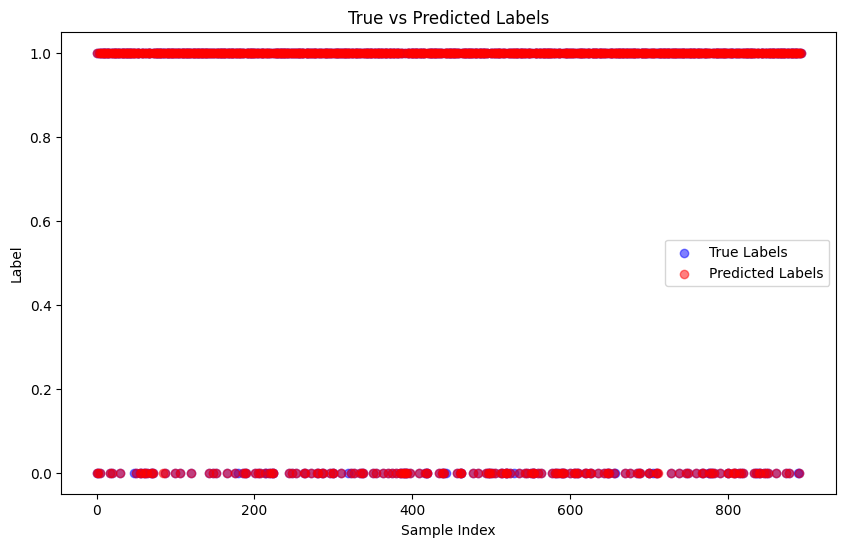

In [68]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ so sánh giữa nhãn thực và nhãn dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Labels', alpha=0.5)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Labels', alpha=0.5)
plt.title('True vs Predicted Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.legend()
plt.show()


### 7.2. Ma trận nhầm lẫn

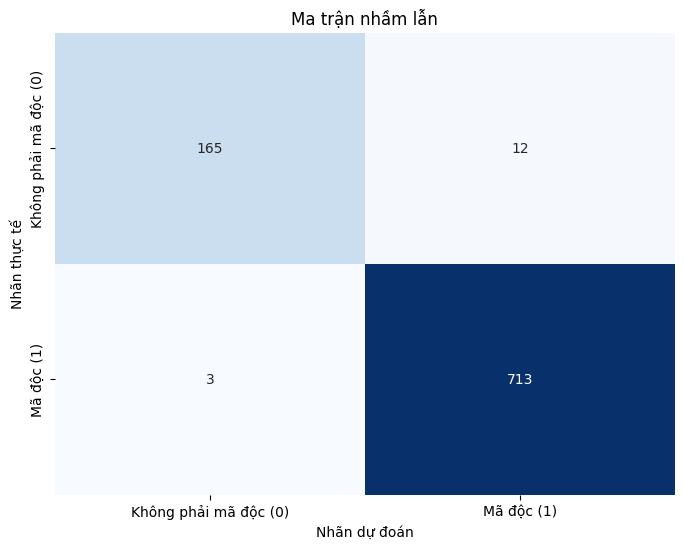

In [69]:
from sklearn.metrics import confusion_matrix

# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Vẽ biểu đồ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Không phải mã độc (0)', 'Mã độc (1)'],
            yticklabels=['Không phải mã độc (0)', 'Mã độc (1)'])
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực tế')
plt.show()


### 7.3. Biểu đồ số lượng dự đoán đúng và sai

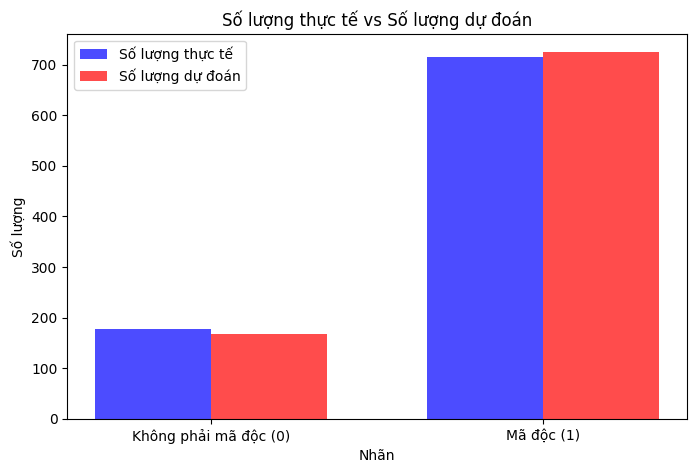

In [70]:
# Tính số lượng dự đoán đúng và sai
true_counts = cm.sum(axis=1)  # Số lượng mẫu thực cho mỗi lớp
predicted_counts = cm.sum(axis=0)  # Số lượng mẫu dự đoán cho mỗi lớp

# Vẽ biểu đồ cột
labels = ['Không phải mã độc (0)', 'Mã độc (1)']
x = np.arange(len(labels))  # Tạo vị trí cho các nhãn

plt.figure(figsize=(8, 5))
bar_width = 0.35

# Tạo các cột cho nhãn thực và nhãn dự đoán
plt.bar(x - bar_width/2, true_counts, bar_width, label='Số lượng thực tế', alpha=0.7, color='blue')
plt.bar(x + bar_width/2, predicted_counts, bar_width, label='Số lượng dự đoán', alpha=0.7, color='red')

plt.title('Số lượng thực tế vs Số lượng dự đoán')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.xticks(x, labels)  # Nhãn cho trục x
plt.legend()
plt.show()


## 8. Kết Luận
Mô hình Random Forest được xây dựng trong báo cáo này đã đạt được độ chính xác ấn tượng khi phát hiện mã độc. Việc sử dụng phương pháp học tập tập hợp (ensemble learning) thông qua Random Forest giúp cải thiện khả năng phân loại so với các mô hình đơn lẻ.